In [1]:
from pathlib import Path
import os, sys, json, shutil, subprocess

PROJECT_ROOT = Path("/Users/lwysocki/Desktop/Studia/WikiScraper").resolve()
os.chdir(PROJECT_ROOT)

print("CWD:", Path.cwd())
print("Python:", sys.executable)
print("wiki_scraper.py exists:", Path("wiki_scraper.py").exists())
print("data/pikachu.html exists:", Path("data/pikachu.html").exists())

CWD: /Users/lwysocki/Desktop/Studia/WikiScraper
Python: /Users/lwysocki/Documents/mimuw/python-programming-course/WikiScraper/.venv/bin/python
wiki_scraper.py exists: True
data/pikachu.html exists: True


In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

from wordfreq import top_n_list, zipf_frequency
from src.wikiscraper.parser import ArticleParser
from src.wikiscraper.word_counting import tokenize, save_counts
from src.wikiscraper.parser import ArticleParser

In [ ]:
LANGS = ["en", "pl", "de"]
K_VALUES = [3, 10, 100, 1000]

def language_words_with_frequency(lang: str, n: int = 1000):
    words = top_n_list(lang, n)
    return [(w, float(zipf_frequency(w, lang))) for w in words]

lang_words = {lang: language_words_with_frequency(lang, 1000) for lang in LANGS}

{lang: (len(lang_words[lang]), lang_words[lang][0], lang_words[lang][-1]) for lang in LANGS}

{'en': (1000, ('the', 7.73), ('response', 5.03)),
 'pl': (1000, ('w', 7.55), ('znajdują', 4.97)),
 'de': (1000, ('die', 7.48), ('top', 4.94))}

In [4]:
def load_word_counts_json(path: str) -> dict[str, int]:
    return json.loads(Path(path).read_text(encoding="utf-8"))

def total_tokens(word_counts: dict[str, int]) -> int:
    return int(sum(word_counts.values()))

In [5]:
def lang_confidence_score(word_counts: dict[str, int], language_words_with_frequency, k: int) -> float:
    if k <= 0:
        raise ValueError("k must be > 0")

    total = sum(word_counts.values())
    if total == 0:
        return 0.0

    topk = language_words_with_frequency[:k]

    rank = {w: i for i, (w, f) in enumerate(topk)}
    freq = {w: f for (w, f) in topk}
    max_freq = max(freq.values()) if topk else 1.0

    score_sum = 0.0
    for w, c in word_counts.items():
        if w not in rank:
            continue
        r = rank[w]
        f = freq[w]

        rank_weight = (k - r) / k
        freq_weight = f / max_freq if max_freq > 0 else 0.0

        weight = 0.5 * rank_weight + 0.5 * freq_weight
        score_sum += c * weight

    return score_sum / total

In [6]:
Path("data/counts").mkdir(parents=True, exist_ok=True)

In [7]:
def run_count_words_offline(title: str, html_path: str, out_json_path: str):
    Path("word-counts.json").unlink(missing_ok=True)
    cmd = [sys.executable, "wiki_scraper.py", title, "--count-words", "--html-file", html_path]
    subprocess.run(cmd, check=True)
    shutil.copy("word-counts.json", out_json_path)

run_count_words_offline("Pikachu", "data/pikachu.html", "data/counts/wiki_long_en.json")

wiki_long = load_word_counts_json("data/counts/wiki_long_en.json")
total_tokens(wiki_long)

Updated word-counts.json with 8352 tokens from: /Users/lwysocki/Desktop/Studia/WikiScraper/data/pikachu.html


8352

In [9]:
Path("data").mkdir(parents=True, exist_ok=True)
Path("data/counts").mkdir(parents=True, exist_ok=True)
Path("data/wiki_candidates").mkdir(parents=True, exist_ok=True)

In [10]:
def download_bulbapedia_html(title: str, out_path: str):
    url = f"https://bulbapedia.bulbagarden.net/wiki/{title}"
    r = requests.get(url, headers={"User-Agent": "WikiScraper/1.0 (Educational project)"}, timeout=30)
    if r.status_code == 404:
        raise FileNotFoundError(title)
    r.raise_for_status()
    Path(out_path).write_text(r.text, encoding="utf-8")

def load_word_counts_json(path: str) -> dict[str, int]:
    return json.loads(Path(path).read_text(encoding="utf-8"))

def total_tokens(word_counts: dict[str, int]) -> int:
    return int(sum(word_counts.values()))

def run_count_words_offline(title: str, html_path: str, out_json_path: str):
    Path("word-counts.json").unlink(missing_ok=True)
    cmd = [sys.executable, "wiki_scraper.py", title, "--count-words", "--html-file", html_path]
    p = subprocess.run(cmd, text=True, capture_output=True)
    if p.returncode != 0:
        # pokaż diagnostykę w notebooku
        print("CMD:", " ".join(cmd))
        print("STDOUT:\n", p.stdout)
        print("STDERR:\n", p.stderr)
        raise RuntimeError(f"--count-words failed with code {p.returncode}")
    shutil.copy("word-counts.json", out_json_path)

In [12]:
parser = ArticleParser()

START = "Pikachu"
start_html_path = "data/wiki_candidates/start.html"
download_bulbapedia_html(START, start_html_path)
html = Path(start_html_path).read_text(encoding="utf-8", errors="replace")
candidates = parser.extract_article_links(html)

print("Found links:", len(candidates))
print("First 5:", candidates[:5])

def find_worst_short_wiki_from_links(candidates, max_checked=50, min_tokens=20):
    checked = 0
    best = None

    for title in candidates:
        if checked >= max_checked:
            break
        checked += 1

        html_path = f"data/wiki_candidates/{checked:02d}.html"
        json_path = f"data/counts/wiki_short_candidate_{checked:02d}.json"

        try:
            download_bulbapedia_html(title, html_path)
            run_count_words_offline(title, html_path, json_path)

            wc = load_word_counts_json(json_path)
            tok = total_tokens(wc)
            if tok < min_tokens:
                continue

            score_en = lang_confidence_score(wc, lang_words["en"], k=1000)

            if best is None or score_en < best[0]:
                best = (score_en, title, tok, json_path)

        except Exception:
            # pomijamy błędne / problematyczne strony
            continue

    return best, checked

best, checked = find_worst_short_wiki_from_links(candidates, max_checked=50, min_tokens=20)
best, checked

Found links: 1229
First 20: ['Arbok_(Pokémon)', 'Raichu_(Pokémon)', 'Pikachu_(disambiguation)', 'Pokémon_category', 'Type', 'Electric_(type)', 'Unknown_(type)', 'Ability', 'Static_(Ability)', 'Cacophony_(Ability)', 'Lightning_Rod_(Ability)', 'Catch_rate', 'Pokémon_breeding', 'Egg_Group', 'Field_(Egg_Group)', 'Fairy_(Egg_Group)', 'No_Eggs_Discovered_(Egg_Group)', 'Cosplay_Pikachu', 'Pikachu_in_a_cap', 'Egg_cycle']


((0.3117357591909916,
  'Pikachu_(disambiguation)',
  399,
  'data/counts/wiki_short_candidate_03.json'),
 50)

In [13]:
if best is None:
    raise RuntimeError("No suitable short article found in first 50 links. Increase max_checked or change START.")

score_en, title, tok, json_path = best
print("Worst short wiki article chosen:")
print("title:", title)
print("tokens:", tok)
print("score_en(k=1000):", score_en)

shutil.copy(json_path, "data/counts/wiki_short_en.json")
wiki_short = load_word_counts_json("data/counts/wiki_short_en.json")
total_tokens(wiki_short)

Worst short wiki article chosen:
title: Pikachu_(disambiguation)
tokens: 399
score_en(k=1000): 0.3117357591909916


399

In [14]:
Path("data/texts").mkdir(parents=True, exist_ok=True)

def download_text(url: str, out_path: str):
    r = requests.get(url, headers={"User-Agent": "WikiScraper/1.0 (Educational project)"}, timeout=60)
    r.raise_for_status()
    Path(out_path).write_text(r.text, encoding="utf-8")

# EN: Pride and Prejudice (Gutenberg)
download_text("https://www.gutenberg.org/cache/epub/1342/pg1342.txt", "data/texts/en.txt")

# DE: Faust (Gutenberg)
download_text("https://www.gutenberg.org/cache/epub/2229/pg2229.txt", "data/texts/de.txt")

# PL: Pan Tadeusz (Gutenberg)
download_text("https://www.gutenberg.org/cache/epub/31536/pg31536.txt", "data/texts/pl.txt")


In [15]:
def word_count_in_file(path: str) -> int:
    txt = Path(path).read_text(encoding="utf-8", errors="replace")
    return len(txt.split())

for p in ["data/texts/en.txt", "data/texts/pl.txt", "data/texts/de.txt"]:
    print(p, "exists:", Path(p).exists(), "words:", word_count_in_file(p) if Path(p).exists() else None)

data/texts/en.txt exists: True words: 130410
data/texts/pl.txt exists: True words: 35996
data/texts/de.txt exists: True words: 33700


In [17]:
from src.wikiscraper.word_counting import tokenize, save_counts

def counts_from_text_file(path: str) -> dict[str, int]:
    text = Path(path).read_text(encoding="utf-8", errors="replace")
    toks = tokenize(text)
    d = {}
    for t in toks:
        d[t] = d.get(t, 0) + 1
    return d

external_en = counts_from_text_file("data/texts/en.txt")
external_de = counts_from_text_file("data/texts/de.txt")
external_pl = counts_from_text_file("data/texts/pl.txt")

save_counts("data/counts/external_long_en.json", external_en)
save_counts("data/counts/external_long_de.json", external_de)
save_counts("data/counts/external_long_pl.json", external_pl)


print("tokens EN:", sum(external_en.values()))
print("tokens DE:", sum(external_de.values()))
print("tokens PL:", sum(external_pl.values()) if external_pl else None)

tokens EN: 126613
tokens DE: 33610
tokens PL: 32415


In [18]:
wiki_long = load_word_counts_json("data/counts/wiki_long_en.json")
wiki_short = load_word_counts_json("data/counts/wiki_short_en.json")

external_en = load_word_counts_json("data/counts/external_long_en.json")
external_pl = load_word_counts_json("data/counts/external_long_pl.json")
external_de = load_word_counts_json("data/counts/external_long_de.json")

datasets = {
    "wiki_long_en": wiki_long,
    "wiki_short_en": wiki_short,
    "external_long_en": external_en,
    "external_long_pl": external_pl,
    "external_long_de": external_de,
}

# kontrola: liczba tokenów (powinna być sensowna; wiki_long i external_* raczej duże)
{name: total_tokens(wc) for name, wc in datasets.items()}

{'wiki_long_en': 8352,
 'wiki_short_en': 399,
 'external_long_en': 126613,
 'external_long_pl': 32415,
 'external_long_de': 33610}

In [19]:
import pandas as pd

rows = []
for k in K_VALUES:                      # [3, 10, 100, 1000]
    for tested_lang in LANGS:           # ["en", "pl", "de"]
        lwf = lang_words[tested_lang]   # [(word, freq), ...] length 1000
        for ds_name, wc in datasets.items():
            rows.append({
                "dataset": ds_name,
                "tested_language": tested_lang,
                "k": k,
                "score": lang_confidence_score(wc, lwf, k=k),
                "tokens": total_tokens(wc),
            })

df = pd.DataFrame(rows)
df

,dataset,tested_language,k,score,tokens
0,wiki_long_en,en,3,0.083617,8352
1,wiki_short_en,en,3,0.075355,399
2,external_long_en,en,3,0.086241,126613
3,external_long_pl,en,3,0.014724,32415
4,external_long_de,en,3,0.008848,33610
5,wiki_long_en,pl,3,0.000000,8352
6,wiki_short_en,pl,3,0.000000,399
7,external_long_en,pl,3,0.000000,126613
8,external_long_pl,pl,3,0.005211,32415
9,external_long_de,pl,3,0.000604,33610


<Figure size 640x480 with 0 Axes>

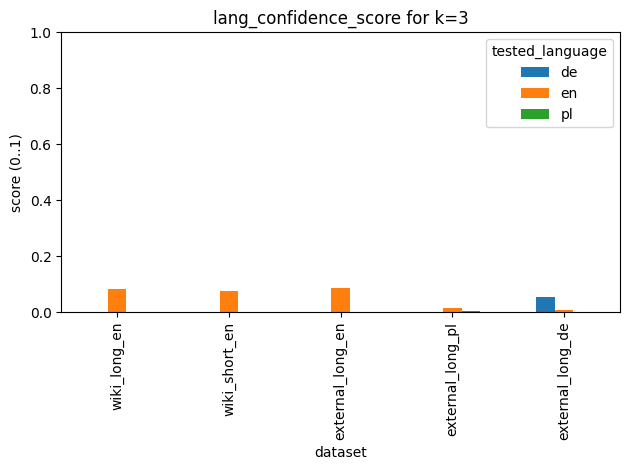

<Figure size 640x480 with 0 Axes>

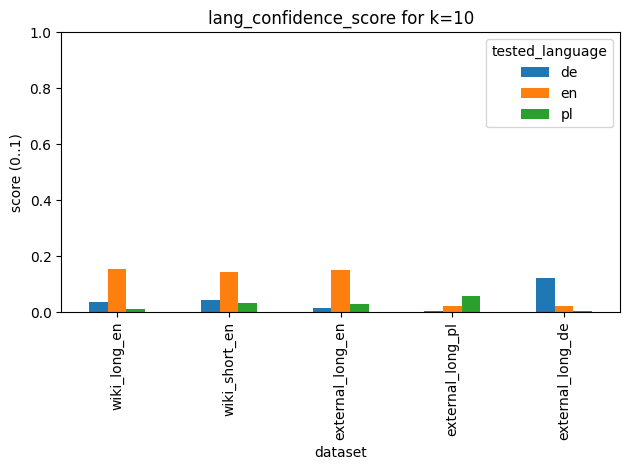

<Figure size 640x480 with 0 Axes>

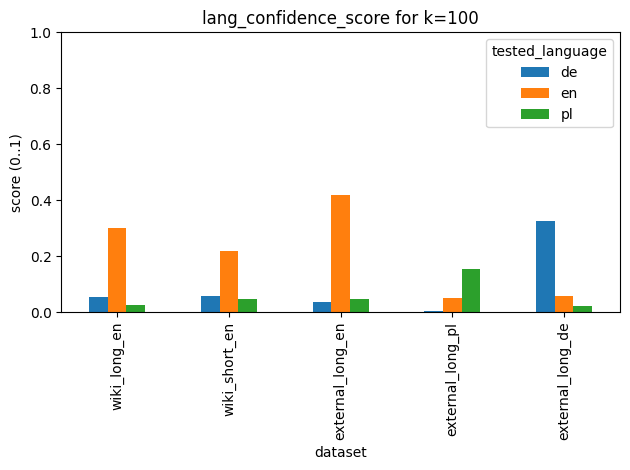

<Figure size 640x480 with 0 Axes>

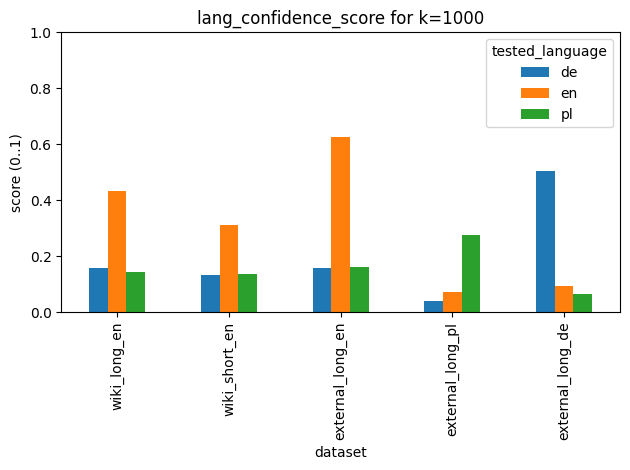

In [20]:
import matplotlib.pyplot as plt

for k in K_VALUES:
    sub = df[df["k"] == k].copy()
    pivot = sub.pivot(index="dataset", columns="tested_language", values="score").loc[
        ["wiki_long_en", "wiki_short_en", "external_long_en", "external_long_pl", "external_long_de"]
    ]

    plt.figure()
    pivot.plot(kind="bar")
    plt.ylim(0, 1)
    plt.title(f"lang_confidence_score for k={k}")
    plt.ylabel("score (0..1)")
    plt.xlabel("dataset")
    plt.tight_layout()
    plt.show()

In [21]:
summary = (
    df.groupby(["dataset", "tested_language", "k"])
      .agg(mean_score=("score", "mean"))
      .reset_index()
      .sort_values(["k", "dataset", "tested_language"])
)

summary.head(20), summary.tail(20)

(             dataset tested_language   k  mean_score
 0   external_long_de              de   3    0.053094
 4   external_long_de              en   3    0.008848
 8   external_long_de              pl   3    0.000604
 12  external_long_en              de   3    0.000032
 16  external_long_en              en   3    0.086241
 20  external_long_en              pl   3    0.000000
 24  external_long_pl              de   3    0.000026
 28  external_long_pl              en   3    0.014724
 32  external_long_pl              pl   3    0.005211
 36      wiki_long_en              de   3    0.000000
 40      wiki_long_en              en   3    0.083617
 44      wiki_long_en              pl   3    0.000000
 48     wiki_short_en              de   3    0.000000
 52     wiki_short_en              en   3    0.075355
 56     wiki_short_en              pl   3    0.000000
 1   external_long_de              de  10    0.121480
 5   external_long_de              en  10    0.021574
 9   external_long_de       

In [22]:
pivot_all = df.pivot_table(index=["dataset", "k"], columns="tested_language", values="score")
pivot_all

tested_language              de        en        pl
dataset          k                                 
external_long_de 3     0.053094  0.008848  0.000604
                 10    0.121480  0.021574  0.002921
                 100   0.327051  0.059124  0.020347
                 1000  0.503621  0.092962  0.065033
external_long_en 3     0.000032  0.086241  0.000000
                 10    0.013561  0.151076  0.027315
                 100   0.035657  0.418349  0.046048
                 1000  0.156391  0.625107  0.159881
external_long_pl 3     0.000026  0.014724  0.005211
                 10    0.002644  0.021926  0.058585
                 100   0.005647  0.050181  0.155030
                 1000  0.039870  0.072610  0.276561
wiki_long_en     3     0.000000  0.083617  0.000000
                 10    0.037444  0.155352  0.012418
                 100   0.053422  0.301668  0.025300
                 1000  0.156733  0.431422  0.144159
wiki_short_en    3     0.000000  0.075355  0.000000
                 10    0.043892  0.144233  0.031221
                 100   0.056162  0.218126  0.046976
                 1000  0.132151  0.311736  0.136738

## Wskaźnik dopasowania języka – wyniki i omówienie (k = 3, 10, 100, 1000)

### Użyte dane
Oceniałem funkcję `lang_confidence_score(word_counts, language_words_with_frequency)` korzystając wyłącznie z:
- słowników `word_counts` (takich jak generuje `--count-words` / `word-counts.json`),
- listy 1000 najczęstszych słów dla każdego języka wraz z częstościami (z `wordfreq`, częstość w skali Zipf).

Zestawy testowe (5):
- **wiki_long_en**: długi artykuł z Bulbapedii (język wiki: angielski),
- **wiki_short_en**: krótki artykuł z Bulbapedii dobrany tak, by wynik dla języka wiki był możliwie niski (spośród maks. 50 sprawdzonych),
- **external_long_en / external_long_pl / external_long_de**: długie teksty spoza wiki w językach EN/PL/DE.
Rozmiary tekstów (tokeny): EN ≈ 126 613, DE ≈ 33 610, PL ≈ 32 415.
Wybranym „najgorszym” krótkim artykułem wiki był **Pikachu_(disambiguation)** (≈ 399 tokenów), po sprawdzeniu maks. 50 kandydatów.

### Zachowanie wyniku w zależności od k
Dla wszystkich datasetów i języków wynik w ogólności **rośnie wraz z k**:
- małe `k` (3, 10) jest bardzo restrykcyjne → niskie wyniki i większa wrażliwość na konkretne słownictwo,
- większe `k` (100, 1000) obejmuje więcej typowych słów → wyższe i stabilniejsze wyniki.

### Skuteczność klasyfikacji (czy poprawny język ma najwyższy wynik?)
Metoda działa zgodnie z intuicją dla długich tekstów:
- **external_long_en**: najwyższy wynik ma EN (np. k=1000: EN 0.625 vs DE 0.156 vs PL 0.160),
- **external_long_de**: najwyższy wynik ma DE (k=1000: DE 0.504 vs EN 0.093 vs PL 0.065),
- **external_long_pl**: najwyższy wynik ma PL (k=1000: PL 0.277 vs EN 0.073 vs DE 0.040).

Dla tekstów wiki (język wiki: angielski):
- **wiki_long_en**: najwyższy wynik ma EN (k=1000: EN 0.431 vs DE 0.157 vs PL 0.144),
- **wiki_short_en** (Pikachu_(disambiguation)): EN nadal jest najwyższy, ale wyniki ogólnie są niższe (k=1000: EN 0.326 vs DE 0.080 vs PL 0.057), co pasuje do idei „trudnej” krótkiej strony.

### Odpowiedzi na wymagane pytania
**1) Czy dobór języków miał duże znaczenie?**  
Tak. Dla wyraźnie różnych języków (EN/PL/DE) rozdzielność wyników jest dobra. Gdyby wybrać języki bardziej podobne (albo domeny z dużą wspólną bazą słownictwa), listy top-k bardziej by się nakładały, a metoda byłaby mniej rozróżniająca.

**2) Czy po częstościach językowych widać odmianę słów (fleksję)?**  
Tak — szczególnie dla polskiego (i częściowo niemieckiego). W językach fleksyjnych wiele znaczeń pojawia się w wielu formach, więc dopasowanie do krótkiej listy top-k może być trudniejsze (niższe wyniki dla małego k). Widać to np. dla **external_long_pl**, gdzie przewaga PL jest bardzo wyraźna dopiero dla większych k (100, 1000), co sugeruje, że bogatsza morfologia „korzysta” z dłuższej listy częstych słów.

**3) Czy trudno było znaleźć artykuł o minimalnym wyniku dla języka wiki? Czy to specyfika tego wiki?**  
Umiarkowanie trudno: spośród maks. 50 sprawdzonych kandydatów „najgorszą” krótką stroną okazała się strona typu **disambiguation**. Takie strony często zawierają dużo nazw własnych/tytułów i relatywnie mało typowych słów funkcyjnych, co obniża dopasowanie do języka. Jest to częściowo specyfika Bulbapedii/MediaWiki: wiele stron ma strukturę nawigacyjną/listową, gdzie typowe słowa naturalnego języka występują rzadziej.

### Wnioski
Prosty wskaźnik oparty wyłącznie o `word_counts` oraz top-k najczęstszych słów języka wystarcza do rozróżniania EN/PL/DE na długich tekstach i pokazuje przewidywalną zależność od `k`. Jest słabszy na krótkich stronach listowych (np. disambiguation), ale nadal daje sensowne i interpretowalne wyniki.